# AI Accelerated – Episode 2
## CUDA Hello World & Profiling

In this episode, we introduce the **CUDA thread hierarchy**, learn about warps, and write a simple vector addition kernel. We'll also profile our kernel using Nsight.

### 🎯 Learning Goals
- Understand the CUDA thread hierarchy (grid → blocks → threads)
- Learn what warps are and why divergence matters
- Write and run a simple CUDA kernel
- Profile kernel execution with Nsight


### 🧩 Thread Hierarchy
- **Grid**: collection of blocks
- **Block**: collection of threads
- **Thread**: executes kernel instructions

Unique thread index in 1D:
```cpp
int i = blockIdx.x * blockDim.x + threadIdx.x;
```


### 🌀 Warps
- A warp = 32 threads executing in lockstep
- Warp divergence: when threads in a warp take different execution paths
- Efficient CUDA code minimizes warp divergence

### 💻 CUDA Hello World: Vector Add Kernel

In [1]:
%%writefile vector_add.cu
#include <stdio.h>
#include <cuda_runtime.h>

__global__ void vectorAdd(const float *A, const float *B, float *C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) C[i] = A[i] + B[i];
}

int main() {
    const int N = 1 << 16; // 65,536 elements
    size_t size = N * sizeof(float);
    float *h_A = (float*)malloc(size);
    float *h_B = (float*)malloc(size);
    float *h_C = (float*)malloc(size);

    for (int i = 0; i < N; i++) { h_A[i] = 1.0f; h_B[i] = 2.0f; }

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    printf("C[0]=%f C[%d]=%f\n", h_C[0], N-1, h_C[N-1]);

    free(h_A); free(h_B); free(h_C);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    return 0;
}

Writing vector_add.cu


In [2]:
!nvcc -O2 vector_add.cu -o vector_add
!./vector_add

C[0]=3.000000 C[65535]=3.000000


### 🔍 Exercise 1
- Change `threadsPerBlock` to 128, 256, 512.
- Observe how `blocksPerGrid` changes.
- Confirm output correctness.


### 🔍 Exercise 2
- Modify the kernel to print thread IDs:
```cpp
printf("Thread %d (Block %d, Thread %d)\n", i, blockIdx.x, threadIdx.x);
```
- Use a small N (like 64) to keep output readable.


### 📊 Profiling with Nsight
Run the program with NVIDIA profiling tools:

```bash
nvprof ./vector_add
# or with Nsight Systems
nsys profile ./vector_add
```
```
nsys stats report2.nsys-rep
or
nsight-sys report2.nsys-rep
```
Observe:
- Kernel launch overhead
- Number of blocks and threads launched
- Memory throughput


#### Output from "nsight-sys report2.nsys-rep"

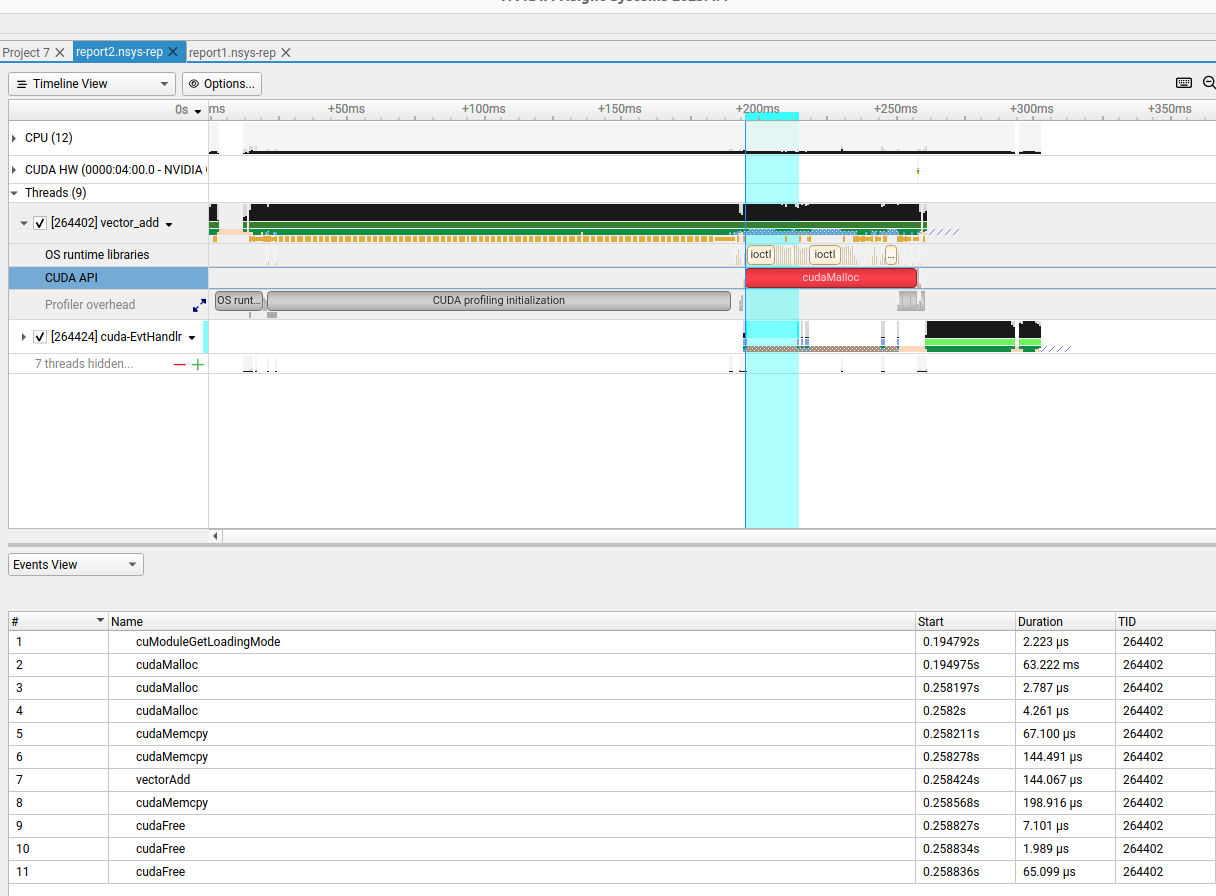

#### Output from "nsys stats report2.nsys-rep"

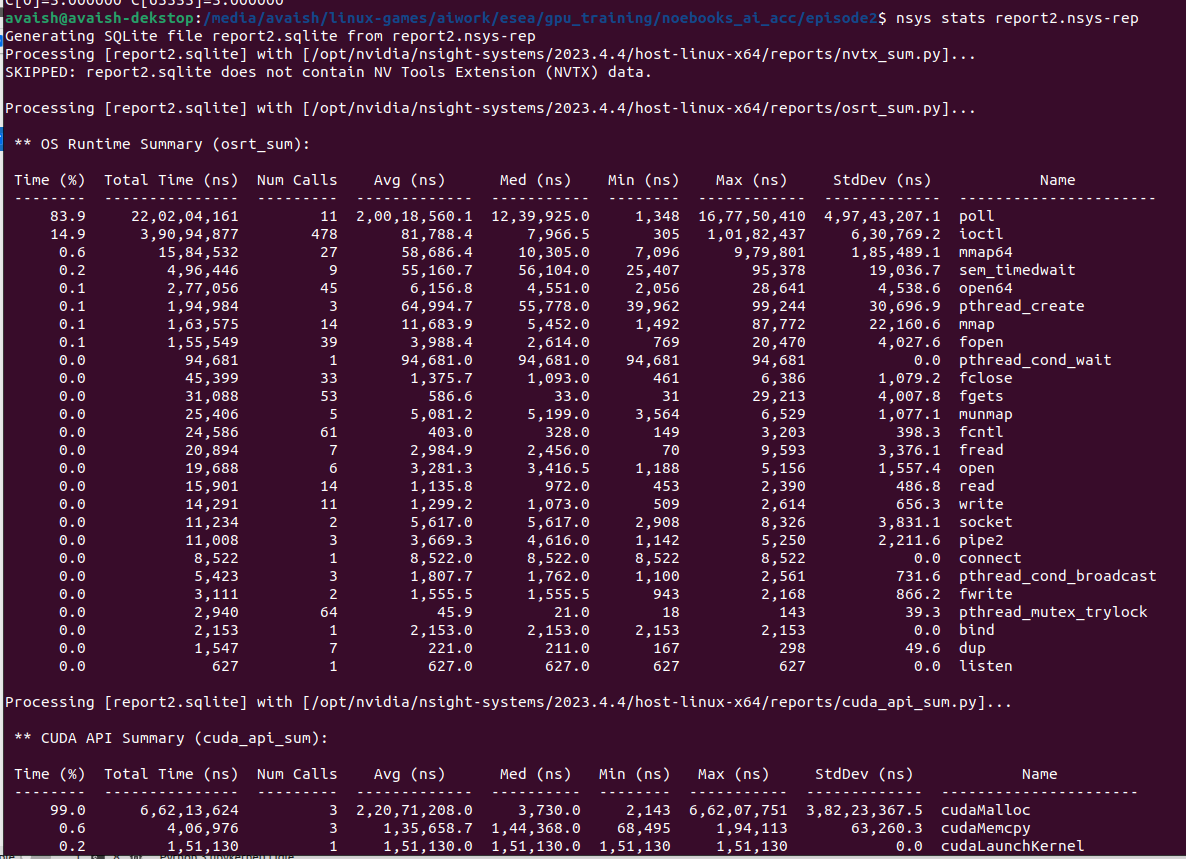

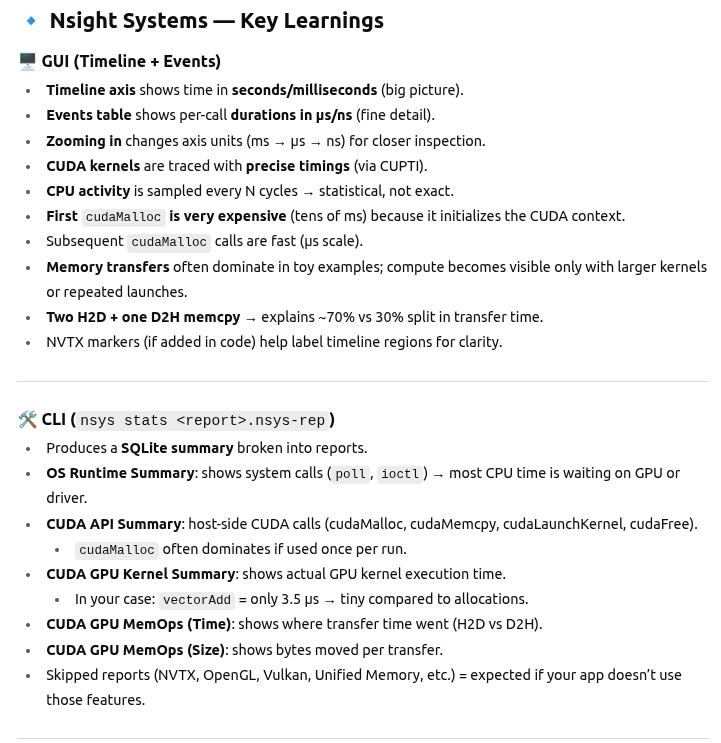

### ✅ Summary
- CUDA organizes work as grid → blocks → threads.
- Warps of 32 threads execute in lockstep.
- Kernel launch syntax controls parallelism.
- Profiling shows how resources are utilized.

➡️ In Episode 3, we’ll dive deeper into the **GPU memory hierarchy** and learn how to optimize memory access.